In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Лабораторная работа 5

## Уравнения в частных производных

### Уравнение переноса

$$ \frac{\partial u(t, x)}{\partial t} + a \cdot \frac{\partial u(t, x)}{\partial x} = f(t, x), \space 0 \leq t \leq T, \space 0 \leq x \leq X $$

$$ u(0, x) = \varphi (x), \space 0 \leq x \leq X $$

$$ u(t, 0) = \psi (t), \space 0 \leq t \leq T $$

Для решения задачи используется равномерная сетка с шагами $\tau$ по времени и $h$ по координате. Функция $u(t, x)$ рассматривается в точках $t = k \tau$, $x = m h$, $0 \leq k \leq K$, $0 \leq m \leq M$, $T = K \tau$, $X = M h$.

### Аналитическое решение

Пусть $u(t, x) = \sin{(k_s x)} \cos{(\omega_t t)}$, где $k_s$ - пространственное волновое число, а $\omega_t$ - временная угловая частота.

Например, $k_s = \frac{\pi}{X}$ (одна полуволна на отрезке $X$), $\omega_t = \frac{\pi}{T}$ (одна полуволна косинуса на отрезке $T$).

Тогда:

$$ \varphi (x) = \sin{(k_s x)} \cos{(0)} = \sin{(k_s x)}; $$

$$ \psi(t) = \sin{(0)} \cos{(\omega_t t)} = 0; $$

$$ \frac{\partial u}{\partial t} = \sin (k_s x) (- \omega_t \sin{(\omega_t t)}) = - \omega_t \sin{(k_s x)} \sin{(\omega_t t)}; $$

$$ \frac{\partial u}{\partial x} = (k_s \cos{(k_s x)}) \cos{(\omega_t t)} = k_s \cos{(k_s x)} \cos {(\omega_t t)};$$

$$ f(t, x) = -\omega_t \sin{(k_s x)} \sin{(\omega_t t)} + a k_s \cos{(k_s x)} \cos{(\omega_t t)}. $$

Мы будем решать задачу при $a = 1$.

### Явный левый уголок

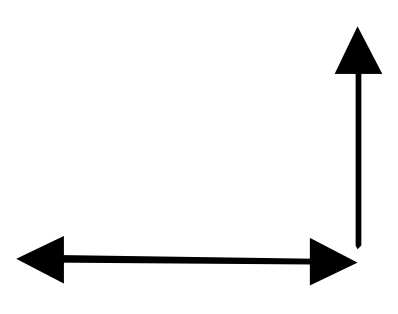

Разностная схема:

$$ (u^{k+1}_m - u^k_m) / \tau + (u^k_m - u^k_{m-1}) / h = f^k_m, \space k = 0, \dots, K - 1, \space m = 0, \dots, M $$

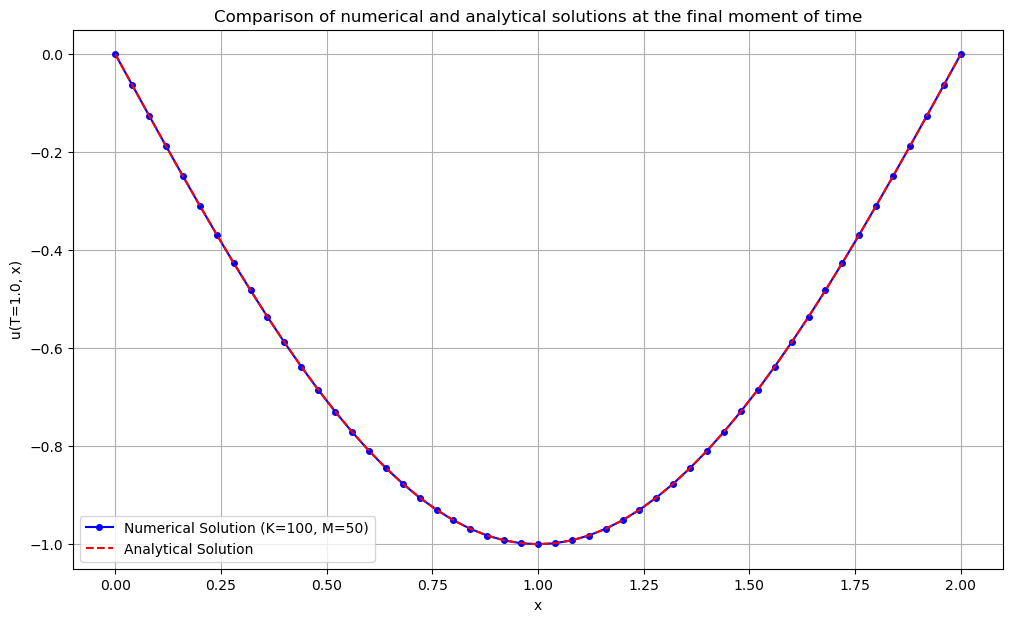

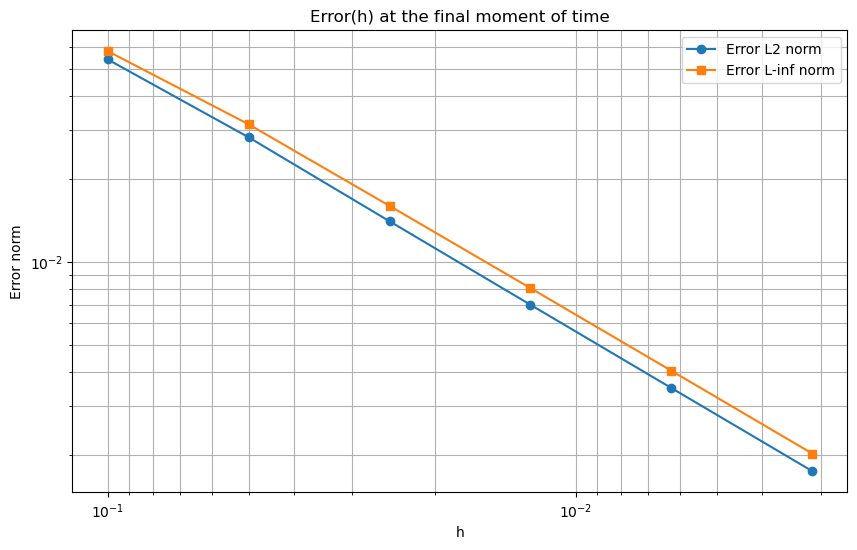

In [4]:
X_domain = 2.0
T_final = 1.0
a_coeff = 1.0

k_spatial = np.pi / X_domain
omega_temporal = np.pi / T_final

def u_analytical_func(t, x):
    return np.sin(k_spatial * x) * np.cos(omega_temporal * t)

def phi_func(x):
    return u_analytical_func(0, x)

def psi_func(t):
    return u_analytical_func(t, 0)

def f_source_func(t, x):
    term_dt = -omega_temporal * np.sin(k_spatial * x) * np.sin(omega_temporal * t)
    term_dx = a_coeff * k_spatial * np.cos(k_spatial * x) * np.cos(omega_temporal * t)
    return term_dt + term_dx

# left corner scheme
def solve_transport_explicit_left_corner(T, X, K, M, a, phi_ic, psi_bc, f_src):
    tau = T / K
    h = X / M
    sigma = a * tau / h

    u_numerical = np.zeros((K + 1, M + 1))
    
    t_grid = np.linspace(0, T, K + 1)
    x_grid = np.linspace(0, X, M + 1)

    u_numerical[0, :] = phi_ic(x_grid)

    u_numerical[:, 0] = psi_bc(t_grid)
    
    for k_idx in range(K):
        for m_idx in range(1, M + 1):
            f_val = f_src(t_grid[k_idx], x_grid[m_idx]) 
            
            u_numerical[k_idx + 1, m_idx] = \
                (1 - sigma) * u_numerical[k_idx, m_idx] + \
                sigma * u_numerical[k_idx, m_idx - 1] + \
                tau * f_val
            
    return t_grid, x_grid, u_numerical

K_vis = 100
M_vis = 50

tau_vis = T_final / K_vis
h_vis = X_domain / M_vis
sigma_vis = a_coeff * tau_vis / h_vis

t_points, x_points, u_num_solution = solve_transport_explicit_left_corner(
                                                                            T_final, X_domain, K_vis, M_vis, a_coeff,
                                                                            phi_func, psi_func, f_source_func
                                                                         )

u_analytical_solution_grid = np.zeros_like(u_num_solution)
for k_idx, t_val in enumerate(t_points):
    for m_idx, x_val in enumerate(x_points):
        u_analytical_solution_grid[k_idx, m_idx] = u_analytical_func(t_val, x_val)

plt.figure(figsize=(12, 7))
plt.plot(x_points, u_num_solution[-1, :], 'bo-', markersize=4, label=f'Numerical Solution (K={K_vis}, M={M_vis})')
plt.plot(x_points, u_analytical_solution_grid[-1, :], 'r--', label='Analytical Solution')
plt.xlabel('x')
plt.ylabel(f'u(T={T_final}, x)')
plt.title('Comparison of numerical and analytical solutions at the final moment of time')
plt.legend()
plt.grid(True)
plt.show()

sigma_target_convergence = 0.8
M_values_convergence = np.array([20, 40, 80, 160, 320, 640])

h_steps_list = []
l2_errors_list = []
linf_errors_list = []

for M_conv in M_values_convergence:
    h_conv = X_domain / M_conv

    tau_conv_ideal = sigma_target_convergence * h_conv / a_coeff
    K_conv = int(np.ceil(T_final / tau_conv_ideal))
    tau_conv_actual = T_final / K_conv
    
    sigma_actual_conv = a_coeff * tau_conv_actual / h_conv
        
    _, x_pts_conv, u_num_conv = solve_transport_explicit_left_corner(
        T_final, X_domain, K_conv, M_conv, a_coeff,
        phi_func, psi_func, f_source_func
    )
    
    u_anal_conv_at_T = np.array([u_analytical_func(T_final, x_val) for x_val in x_pts_conv])
    u_num_conv_at_T = u_num_conv[-1, :]
    
    error_vector = u_num_conv_at_T - u_anal_conv_at_T
    
    l2_error = np.sqrt(h_conv * np.sum(error_vector**2))
    linf_error = np.max(np.abs(error_vector))
    
    h_steps_list.append(h_conv)
    l2_errors_list.append(l2_error)
    linf_errors_list.append(linf_error)

h_steps_np = np.array(h_steps_list)
l2_errors_np = np.array(l2_errors_list)
linf_errors_np = np.array(linf_errors_list)

### Схема Лакса-Вендроффа (явная четырёхточечная схема)

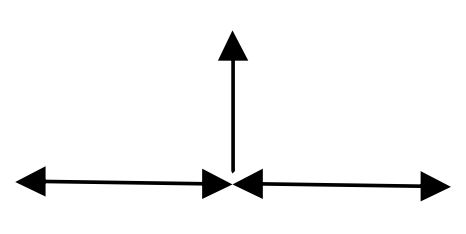

Разностная схема:

$$ (u^{k+1}_m - u^k_m) / \tau + (u^k_{m+1} - u^k_{m-1}) / 2h - 0.5 \tau (u^k_{m+1} - 2 u^k_m + u^k_{m-1}) / h^2 = f^k_m, \space k = 0, \dots, K - 1, \space m = 0, \dots, M - 1 $$

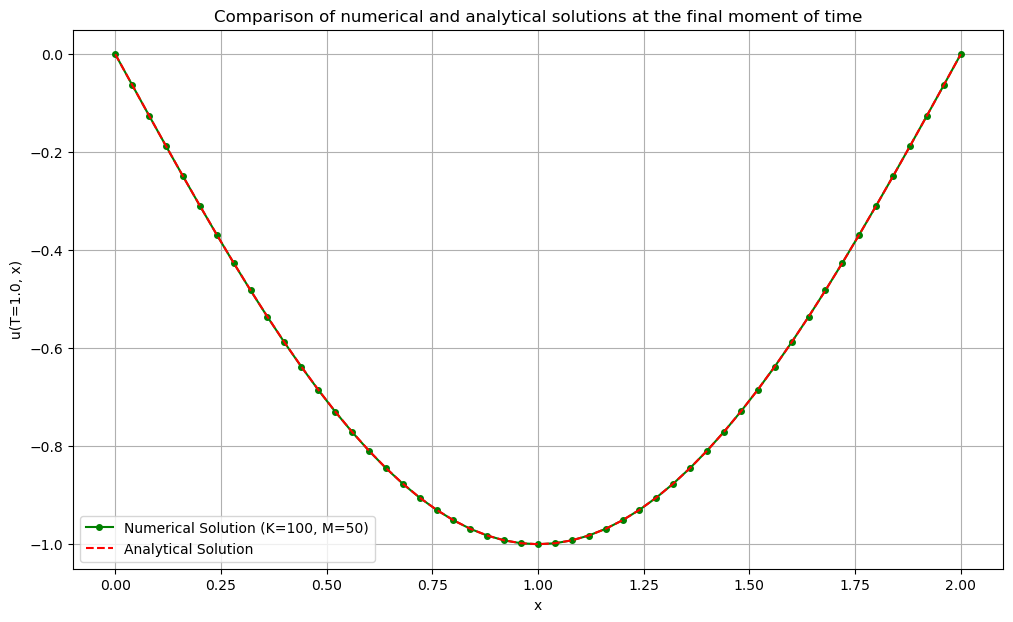

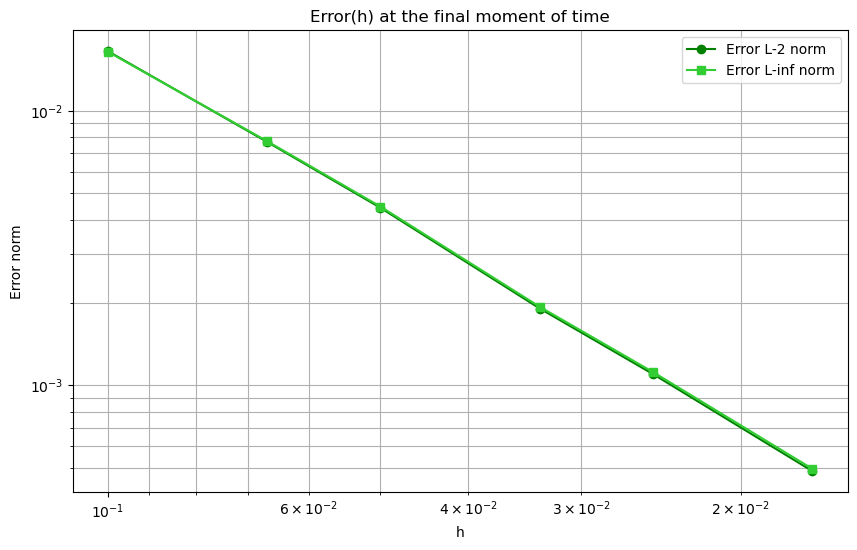

In [6]:
X_domain = 2.0
T_final = 1.0
a_coeff = 1.0

k_spatial = np.pi / X_domain
omega_temporal = np.pi / T_final

def u_analytical_func(t, x):
    return np.sin(k_spatial * x) * np.cos(omega_temporal * t)

def phi_func(x):
    return u_analytical_func(0, x)

def psi_func(t):
    return u_analytical_func(t, 0)

def f_source_func(t, x):
    term_dt = -omega_temporal * np.sin(k_spatial * x) * np.sin(omega_temporal * t)
    term_dx = a_coeff * k_spatial * np.cos(k_spatial * x) * np.cos(omega_temporal * t)
    return term_dt + term_dx

def f_t_source_func(t, x):
    term1 = -omega_temporal**2 * np.sin(k_spatial * x) * np.cos(omega_temporal * t)
    term2 = -a_coeff * k_spatial * omega_temporal * np.cos(k_spatial * x) * np.sin(omega_temporal * t)
    return term1 + term2

def f_x_source_func(t, x):
    term1 = -omega_temporal * k_spatial * np.cos(k_spatial * x) * np.sin(omega_temporal * t)
    term2 = -a_coeff * k_spatial**2 * np.sin(k_spatial * x) * np.cos(omega_temporal * t)
    return term1 + term2

# Lax-Wendroff scheme
def solve_transport_lax_wendroff(T, X, K, M, a, phi_ic, psi_bc_left, 
                                 f_src, f_t_src, f_x_src):
    tau = T / K
    h = X / M
    sigma = a * tau / h
    
    u_numerical = np.zeros((K + 1, M + 1))
    
    t_grid = np.linspace(0, T, K + 1)
    x_grid = np.linspace(0, X, M + 1)

    u_numerical[0, :] = phi_ic(x_grid)

    u_numerical[:, 0] = psi_bc_left(t_grid)
    
    for k_idx in range(K):
        for m_idx in range(1, M):
            f_val   = f_src(t_grid[k_idx], x_grid[m_idx])
            ft_val  = f_t_src(t_grid[k_idx], x_grid[m_idx])
            fx_val  = f_x_src(t_grid[k_idx], x_grid[m_idx])
            
            source_contribution = tau * f_val + (tau**2 / 2) * (ft_val - a * fx_val)
            
            lw_homogeneous_part = (1 - sigma**2) * u_numerical[k_idx, m_idx] + \
                                  (sigma**2 - sigma) / 2 * u_numerical[k_idx, m_idx + 1] + \
                                  (sigma**2 + sigma) / 2 * u_numerical[k_idx, m_idx - 1]
            
            u_numerical[k_idx + 1, m_idx] = lw_homogeneous_part + source_contribution
        
        f_val_M = f_src(t_grid[k_idx], x_grid[M])
        u_numerical[k_idx + 1, M] = \
            (1 - sigma) * u_numerical[k_idx, M] + \
            sigma * u_numerical[k_idx, M - 1] + \
            tau * f_val_M
    
    return t_grid, x_grid, u_numerical

K_vis_lw = 100
M_vis_lw = 50  

tau_vis_lw = T_final / K_vis_lw
h_vis_lw = X_domain / M_vis_lw
sigma_vis_lw = a_coeff * tau_vis_lw / h_vis_lw

t_points_lw, x_points_lw, u_num_lw_solution = solve_transport_lax_wendroff(
    T_final, X_domain, K_vis_lw, M_vis_lw, a_coeff,
    phi_func, psi_func, 
    f_source_func, f_t_source_func, f_x_source_func
)

u_analytical_solution_grid_lw = np.zeros_like(u_num_lw_solution)
for k_idx, t_val in enumerate(t_points_lw):
    for m_idx, x_val in enumerate(x_points_lw):
        u_analytical_solution_grid_lw[k_idx, m_idx] = u_analytical_func(t_val, x_val)

plt.figure(figsize=(12, 7))
plt.plot(x_points_lw, u_num_lw_solution[-1, :], 'go-', markersize=4, label=f'Numerical Solution (K={K_vis_lw}, M={M_vis_lw})')
plt.plot(x_points_lw, u_analytical_solution_grid_lw[-1, :], 'r--', label='Analytical Solution')
plt.xlabel('x')
plt.ylabel(f'u(T={T_final}, x)')
plt.title('Comparison of numerical and analytical solutions at the final moment of time')
plt.legend()
plt.grid(True)
plt.show()

sigma_target_lw_convergence = 0.8
M_values_lw_convergence = np.array([20, 30, 40, 60, 80, 120])

h_steps_lw_list = []
l2_errors_lw_list = []
linf_errors_lw_list = []

for M_conv_lw in M_values_lw_convergence:
    h_conv_lw = X_domain / M_conv_lw
    if a_coeff == 0: tau_conv_lw_ideal = T_final / 100
    else: tau_conv_lw_ideal = abs(sigma_target_lw_convergence * h_conv_lw / a_coeff)
    
    K_conv_lw = int(np.ceil(T_final / tau_conv_lw_ideal))
    tau_conv_lw_actual = T_final / K_conv_lw
    
    sigma_actual_lw_conv = a_coeff * tau_conv_lw_actual / h_conv_lw
        
    _, x_pts_conv_lw, u_num_conv_lw = solve_transport_lax_wendroff(
        T_final, X_domain, K_conv_lw, M_conv_lw, a_coeff,
        phi_func, psi_func, 
        f_source_func, f_t_source_func, f_x_source_func
    )
    
    u_anal_conv_lw_at_T = np.array([u_analytical_func(T_final, x_val) for x_val in x_pts_conv_lw])
    u_num_conv_lw_at_T = u_num_conv_lw[-1, :]
    
    error_vector_lw = u_num_conv_lw_at_T - u_anal_conv_lw_at_T
    
    l2_error_lw = np.sqrt(h_conv_lw * np.sum(error_vector_lw**2))
    linf_error_lw = np.max(np.abs(error_vector_lw))
    
    h_steps_lw_list.append(h_conv_lw)
    l2_errors_lw_list.append(l2_error_lw)
    linf_errors_lw_list.append(linf_error_lw)

h_steps_lw_np = np.array(h_steps_lw_list)
l2_errors_lw_np = np.array(l2_errors_lw_list)
linf_errors_lw_np = np.array(linf_errors_lw_list)

### Прямоугольник

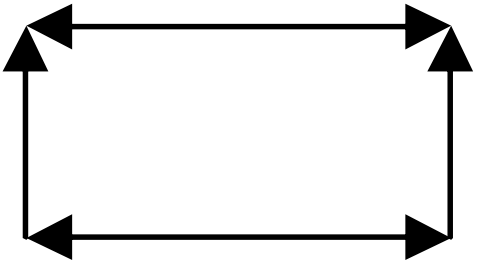

Разностная схема:

$$ (u^{k+1}_{m-1} - u^k_{m-1} + u^{k+1}_m - u^k_m) / 2 \tau + (u^{k+1}_m - u^{k+1}_{m-1} + u^k_m - u^k_{m-1}) / 2 h = f^{k + 1/2}_{m + 1/2}, \space k = 0, \dots, K - 1, \space m = 0, \dots, M $$

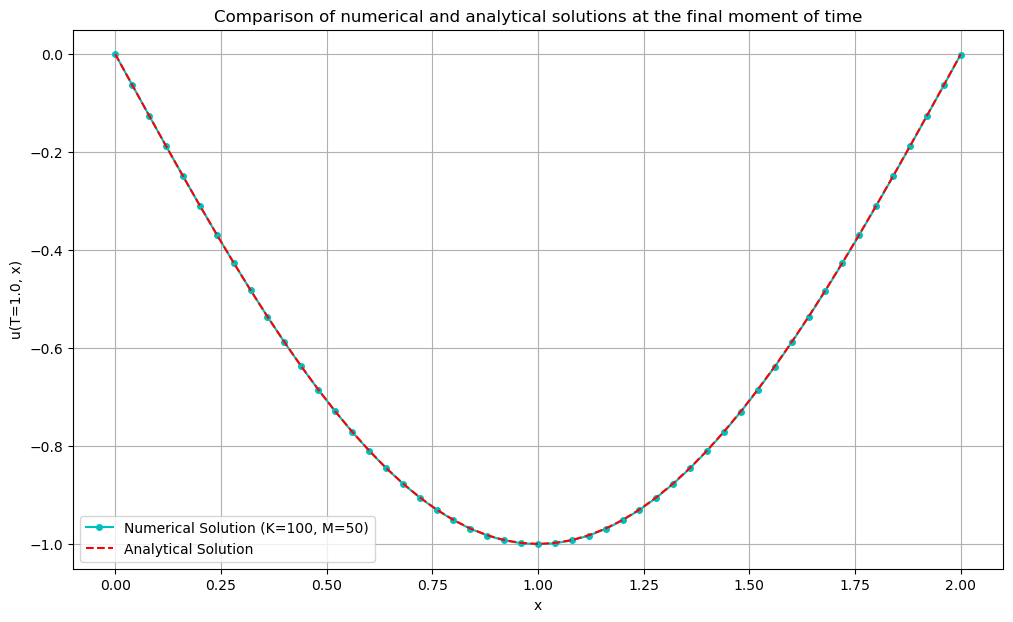

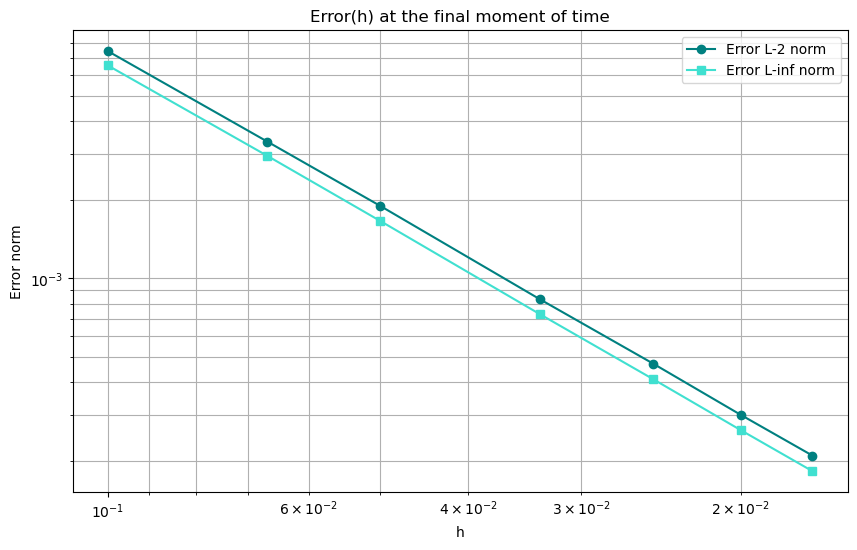

In [8]:
X_domain = 2.0
T_final = 1.0
a_coeff = 1.0

k_spatial = np.pi / X_domain
omega_temporal = np.pi / T_final

def u_analytical_func(t, x):
    return np.sin(k_spatial * x) * np.cos(omega_temporal * t)

def phi_func(x):
    return u_analytical_func(0, x)

def psi_func(t):
    return u_analytical_func(t, 0)

def f_source_func(t, x):
    term_dt = -omega_temporal * np.sin(k_spatial * x) * np.sin(omega_temporal * t)
    term_dx = a_coeff * k_spatial * np.cos(k_spatial * x) * np.cos(omega_temporal * t)
    return term_dt + term_dx

# Box Scheme
def solve_transport_box_scheme(T, X, K, M, a, phi_ic, psi_bc_left, f_src):
    tau = T / K
    h = X / M
    
    u_numerical = np.zeros((K + 1, M + 1))
    t_grid = np.linspace(0, T, K + 1)
    x_grid = np.linspace(0, X, M + 1)

    u_numerical[0, :] = phi_ic(x_grid)

    sigma_h = a * tau / h

    for k_idx in range(K):
        u_k = u_numerical[k_idx, :]       
        t_k = t_grid[k_idx]
        t_k_plus_1 = t_grid[k_idx+1]
        t_k_plus_half = t_k + tau / 2

        u_numerical[k_idx+1, 0] = psi_bc_left(t_k_plus_1)
        
        coeff_denom_inv = 1.0 / (1.0 + sigma_h)
        for m_idx in range(1, M + 1):
            x_m_minus_half = x_grid[m_idx-1] + h / 2.0
            f_val = f_src(t_k_plus_half, x_m_minus_half)
            
            term_ukplus1_m_minus_1 = -(1.0 - sigma_h) * u_numerical[k_idx+1, m_idx-1]
            term_uk_m_minus_1      =  (1.0 + sigma_h) * u_k[m_idx-1]
            term_uk_m              =  (1.0 - sigma_h) * u_k[m_idx]
            term_f_contrib         =  2.0 * tau * f_val
            
            u_numerical[k_idx+1, m_idx] = coeff_denom_inv * (term_ukplus1_m_minus_1 + \
                                                             term_uk_m_minus_1 + \
                                                             term_uk_m + \
                                                             term_f_contrib)
            
    return t_grid, x_grid, u_numerical

K_vis_box = 100 
M_vis_box = 50  

tau_vis_box = T_final / K_vis_box
h_vis_box = X_domain / M_vis_box
sigma_h_vis_box_eff = a_coeff * tau_vis_box / h_vis_box

t_pts_box, x_pts_box, u_num_box_solution = solve_transport_box_scheme(
    T_final, X_domain, K_vis_box, M_vis_box, a_coeff,
    phi_func, psi_func, f_source_func
)

u_analytical_solution_grid_box = np.zeros_like(u_num_box_solution)
for k_idx, t_val in enumerate(t_pts_box):
    for m_idx, x_val in enumerate(x_pts_box):
        u_analytical_solution_grid_box[k_idx, m_idx] = u_analytical_func(t_val, x_val)

plt.figure(figsize=(12, 7))
plt.plot(x_pts_box, u_num_box_solution[-1, :], 'co-', markersize=4, label=f'Numerical Solution (K={K_vis_box}, M={M_vis_box})')
plt.plot(x_pts_box, u_analytical_solution_grid_box[-1, :], 'r--', label='Analytical Solution')
plt.xlabel('x')
plt.ylabel(f'u(T={T_final}, x)')
plt.title('Comparison of numerical and analytical solutions at the final moment of time')
plt.legend()
plt.grid(True)
plt.show()

sigma_h_target_box_convergence = 0.8 
M_values_box_convergence = np.array([20, 30, 40, 60, 80, 100, 120]) 

h_steps_box_list = []
l2_errors_box_list = []
linf_errors_box_list = []

for M_conv_box in M_values_box_convergence:
    h_conv_box = X_domain / M_conv_box
    if a_coeff == 0: tau_conv_box_ideal = T_final / 100 
    else: tau_conv_box_ideal = abs(sigma_h_target_box_convergence * h_conv_box / a_coeff)
    
    K_conv_box = int(np.ceil(T_final / tau_conv_box_ideal))
    tau_conv_box_actual = T_final / K_conv_box
    sigma_h_actual_box_conv = a_coeff * tau_conv_box_actual / h_conv_box
    
    _, x_pts_conv_box, u_num_conv_box = solve_transport_box_scheme(
        T_final, X_domain, K_conv_box, M_conv_box, a_coeff,
        phi_func, psi_func, f_source_func
    )
    
    u_anal_conv_box_at_T = np.array([u_analytical_func(T_final, x_val) for x_val in x_pts_conv_box])
    u_num_conv_box_at_T = u_num_conv_box[-1, :]
    
    error_vector_box = u_num_conv_box_at_T - u_anal_conv_box_at_T
    
    l2_error_box = np.sqrt(h_conv_box * np.sum(error_vector_box**2))
    linf_error_box = np.max(np.abs(error_vector_box))
    
    h_steps_box_list.append(h_conv_box)
    l2_errors_box_list.append(l2_error_box)
    linf_errors_box_list.append(linf_error_box)

h_steps_box_np = np.array(h_steps_box_list)
l2_errors_box_np = np.array(l2_errors_box_list)
linf_errors_box_np = np.array(linf_errors_box_list)

### Зависимости нормы ошибки различных схем от величины шага

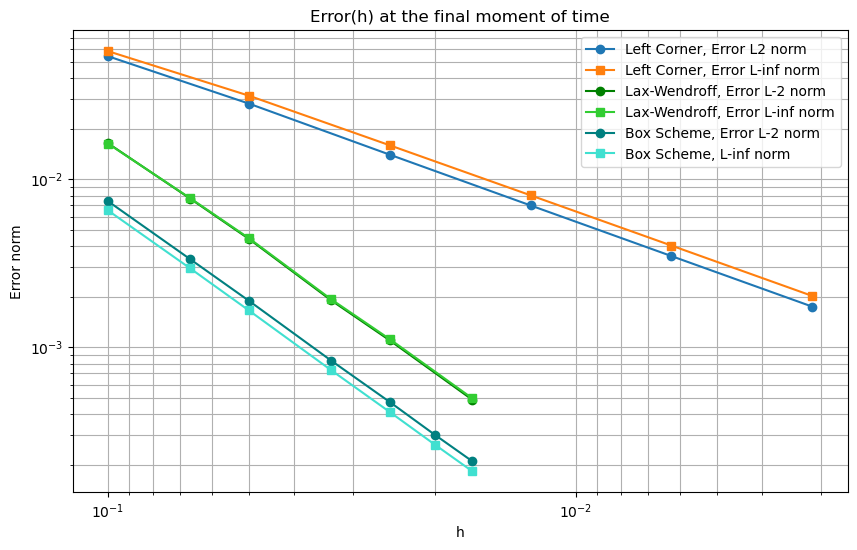

In [17]:
plt.figure(figsize=(10, 6))
plt.loglog(h_steps_np, l2_errors_np, 'o-', label='Left Corner, Error L2 norm')
plt.loglog(h_steps_np, linf_errors_np, 's-', label='Left Corner, Error L-inf norm')

plt.loglog(h_steps_lw_np, l2_errors_lw_np, 'o-', color='green', label='Lax-Wendroff, Error L-2 norm')
plt.loglog(h_steps_lw_np, linf_errors_lw_np, 's-', color='limegreen', label='Lax-Wendroff, Error L-inf norm')

plt.loglog(h_steps_box_np, l2_errors_box_np, 'o-', color='teal', label='Box Scheme, Error L-2 norm')
plt.loglog(h_steps_box_np, linf_errors_box_np, 's-', color='turquoise', label='Box Scheme, L-inf norm')

plt.xlabel('h')
plt.ylabel('Error norm')
plt.title('Error(h) at the final moment of time')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.gca().invert_xaxis()
plt.show()